## Import Dependencies

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [78]:
# setting seed
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

## Preparing Dataset

In [79]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):

    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
        # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
        # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [80]:
load_data("AAPL")["df"]

,open,high,low,close,adjclose,volume,ticker
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101087,469033600.0,AAPL
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095813,175884800.0,AAPL
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088780,105728000.0,AAPL
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090978,86441600.0,AAPL
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093615,73449600.0,AAPL
...,...,...,...,...,...,...,...
2021-01-15,128.779999,130.220001,127.000000,127.139999,127.139999,111598500.0,AAPL
2021-01-19,127.779999,128.710007,126.940002,127.830002,127.830002,90757300.0,AAPL
2021-01-20,128.660004,132.490005,128.550003,132.029999,132.029999,104319500.0,AAPL
2021-01-21,133.800003,139.669998,133.589996,136.869995,136.869995,120150900.0,AAPL


## Create Model

In [81]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

## Training the Model

In [82]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 30
# scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5
# Amazon stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

## Create the folders

In [83]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

## Load Data and Train

In [84]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/5
126/126 [==============================] - 42s 315ms/step - loss: 0.0017 - mean_absolute_error: 0.0235 - val_loss: 1.9334e-04 - val_mean_absolute_error: 0.0084

Epoch 00001: val_loss improved from inf to 0.00019, saving model to results/2021-01-22_AAPL-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-30-layers-2-units-256.h5
Epoch 2/5
126/126 [==============================] - 46s 365ms/step - loss: 4.2205e-04 - mean_absolute_error: 0.0122 - val_loss: 2.6779e-04 - val_mean_absolute_error: 0.0111

Epoch 00002: val_loss did not improve from 0.00019
Epoch 3/5
126/126 [==============================] - 46s 363ms/step - loss: 3.3028e-04 - mean_absolute_error: 0.0115 - val_loss: 3.4872e-04 - val_mean_absolute_error: 0.0122

Epoch 00003: val_loss did not improve from 0.00019
Epoch 4/5
126/126 [==============================] - 46s 362ms/step - loss: 3.7896e-04 - mean_absolute_error: 0.0142 - val_loss: 2.4012e-04 - val_mean_absolute_error: 0.0127

Epoch 00004: val_loss did not improv

## Plot Graph

In [ ]:
!tensorboard --logdir="logs"

## Testing the Model

In [85]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

## Predictions

In [86]:
def get_final_df(model, data):
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [87]:
get_final_df(model, data)

,open,high,low,close,adjclose,volume,ticker,adjclose_30,true_adjclose_30,buy_profit,sell_profit
1981-03-03,0.117746,0.117746,0.117188,0.117188,0.092297,16172800.0,AAPL,-0.239386,0.098010,-0.331683,0.0
1981-03-12,0.100446,0.101004,0.100446,0.100446,0.079111,59248000.0,AAPL,-0.257641,0.101966,-0.336753,0.0
1981-03-13,0.099888,0.099888,0.099330,0.099330,0.078232,231302400.0,AAPL,-0.285365,0.101087,-0.363597,0.0
1981-03-23,0.119420,0.120536,0.119420,0.119420,0.094055,22019200.0,AAPL,-0.257634,0.098889,-0.351688,0.0
1981-04-07,0.115513,0.115513,0.114955,0.114955,0.090539,10684800.0,AAPL,-0.243539,0.099768,-0.334078,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300.0,AAPL,119.657951,131.880005,3.337952,0.0
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300.0,AAPL,121.777100,136.690002,2.567101,0.0
2020-11-18,118.610001,119.820000,118.000000,118.029999,118.029999,76322100.0,AAPL,123.736969,129.410004,5.706970,0.0
2020-11-20,118.639999,118.769997,117.290001,117.339996,117.339996,73604300.0,AAPL,123.599564,126.599998,6.259567,0.0


## Predict future price

In [88]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

## Evaluating the model

In [89]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

## Loss and Mean calculation

In [90]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

## Test Dataframe

In [91]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)
final_df

,open,high,low,close,adjclose,volume,ticker,adjclose_30,true_adjclose_30,buy_profit,sell_profit
1981-03-03,0.117746,0.117746,0.117188,0.117188,0.092297,16172800.0,AAPL,0.001062,1.003602,-0.091234,0.000000
1981-03-12,0.100446,0.101004,0.100446,0.100446,0.079111,59248000.0,AAPL,0.038277,1.062293,-0.040834,0.000000
1981-03-13,0.099888,0.099888,0.099330,0.099330,0.078232,231302400.0,AAPL,-0.345110,0.231067,-0.423343,0.000000
1981-03-23,0.119420,0.120536,0.119420,0.119420,0.094055,22019200.0,AAPL,1.782974,2.658505,1.688920,0.000000
1981-04-07,0.115513,0.115513,0.114955,0.114955,0.090539,10684800.0,AAPL,31.401659,29.759630,31.311120,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300.0,AAPL,-0.294073,0.119985,0.000000,116.614073
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300.0,AAPL,-0.131274,0.151630,0.000000,119.341273
2020-11-18,118.610001,119.820000,118.000000,118.029999,118.029999,76322100.0,AAPL,-0.035896,0.420100,0.000000,118.065894
2020-11-20,118.639999,118.769997,117.290001,117.339996,117.339996,73604300.0,AAPL,-0.409586,0.117348,0.000000,117.749582


## Get future price

In [92]:
# predict the future price
future_price = predict(model, data)
future_price

136.69794

## Count of Positive Profit

In [93]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

## Print metrics

In [94]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 30 days is 136.70$
huber_loss loss: 0.00018122026813216507
Mean Absolute Error: 1.2384207163951833
Accuracy score: 0.8315894369706028
Total buy profit: 15033.205924205773
Total sell profit: 14727.665616894432
Total profit: 29760.871541100205
Profit per trade: 14.82853589491789


## Plot actual prediction

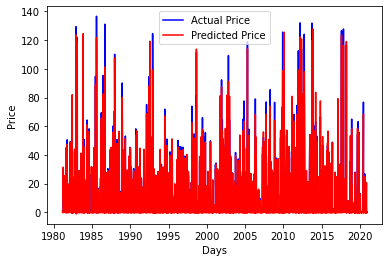

In [95]:
# plot true/pred prices graph
plot_graph(final_df)

In [96]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                  open        high         low       close    adjclose  \
2020-09-24  105.169998  110.250000  105.000000  108.220001  108.033615   
2020-10-12  120.059998  125.180000  119.279999  124.400002  124.185753   
2020-10-16  121.279999  121.550003  118.809998  119.019997  118.815010   
2020-10-30  111.059998  111.989998  107.720001  108.860001  108.672516   
2020-11-03  109.660004  111.489998  108.730003  110.440002  110.249794   
2020-11-09  120.500000  121.989998  116.050003  116.320000  116.320000   
2020-11-12  119.620003  120.529999  118.570000  119.209999  119.209999   
2020-11-18  118.610001  119.820000  118.000000  118.029999  118.029999   
2020-11-20  118.639999  118.769997  117.290001  117.339996  117.339996   
2020-11-24  113.910004  115.849998  112.589996  115.169998  115.169998   

                 volume ticker  adjclose_30  true_adjclose_30  buy_profit  \
2020-09-24  167743300.0   AAPL    -0.666890          0.357673         0.0   
2020-10-12  240226800.0   AAPL 